In [ ]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D(Problem):
    """
    Solves the 1D time-dependent Schrödinger equation:

         i ψ_t = -½ ψ_{xx} + |ψ|² ψ,

    where the complex wavefunction ψ is split into real and imaginary parts:
         ψ(x,t) = u(x,t) + i v(x,t).

    This leads to a coupled system of two real PDEs:
    
         - v_t + ½ u_{xx} + (u² + v²) u = 0,   (Equation 1)
         u_t + ½ v_{xx} + (u² + v²) v = 0.      (Equation 2)
    
    The initial condition is chosen to be the ground state of the harmonic oscillator:
    
         ψ(x,0) = ψ₀(x) = 2sech(x) = 2/cosh(x)
    
    so that u(x,0) = ψ₀(x) and v(x,0) = 0.
    
    The spatial domain is chosen as x ∈ [-L, L] (with L sufficiently large so that ψ ≈ 0 at x = ±L)
    and time t ∈ [0, T].
    """

    @staticmethod
    def init_params(omega=1.0, L=5.0, sd=0.1):
        # Define the dimensionality:
        #   ud = 2 (u, v)
        #   xd = 2 (x, t)
        static_params = {
            "dims": (2, 2),
            "omega": omega,
            "L": L,
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        
        # For the two equations, we need the following derivatives:
        # For Equation (1): we require u, u_{xx} and v_t.
        # For Equation (2): we require v, v_{xx} and u_t.
        required_diffs = (
            (0, ()),     # u
            (0, (0, 0)), # u_xx
            (1, (1,)),   # v_t
            (1, ()),     # v
            (1, (0, 0)), # v_xx
            (0, (1,)),   # u_t
        )
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Enforces both the initial condition and the boundary conditions.
        """

        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        omega = all_params["static"]["problem"]["omega"]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]
        tanh = jax.nn.tanh
        
        # Constraining function
        c = tanh((L+x)/sd) * tanh((L-x)/sd)
        
        # Define the initial condition (ground state of the harmonic oscillator)
        psi0 = 2.0/jnp.cosh(x)
        
        # Split the raw network output into its two components.
        u = net_out[:, 0:1]
        v = net_out[:, 1:2]
        
        # Reparameterize to enforce the conditions.
        u = c * t * u + psi0
        v = c * t * v
        # Concatenate u and v to form the full two-component output.
        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Computes the physics residual for both equations:
        
        The loss is defined as the sum of the mean squared errors of the residuals for
        both equations.
        """
        omega = all_params["static"]["problem"]["omega"]
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]
        
        x = x_batch[:, 0:1]
        
        # res1 = -vt + 0.5 * uxx - 0.5 * omega**2 * (x**2) * u
        # res2 = ut + 0.5 * vxx - 0.5 * omega**2 * (x**2) * v
        res1 = -vt + 0.5 * uxx + (u**2 + v**2) * u
        res2 = ut + 0.5 * vxx + (u**2 + v**2) * v
        
        loss1 = jnp.mean(res1**2)
        loss2 = jnp.mean(res2**2)
        return loss1 + loss2

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        No closed form exact solution. Returns zeros.
        """
        omega = all_params["static"]["problem"]["omega"]
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        sech = lambda z: 1.0/jnp.cosh(z)
        u = omega * sech(omega * x) * jnp.cos( (omega**2 * t)/2.0 )
        v = omega * sech(omega * x) * jnp.sin( (omega**2 * t)/2.0 )
        return jnp.zeros_like(jnp.concatenate([u, v], axis=1))


[Errno 16] Device or resource busy: 'results/summaries/test/.nfs000000005a54a6f300003a1c'
[INFO] 2025-04-01 20:49:30 - <fbpinns.constants.Constants object at 0x72e9ad7724e0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-5.,  0.]), 'xmax': array([5.        , 1.57079633])}
problem: <class '__main__.Schrodinger1D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ]), array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633])], 'subdomain_ws': [array([1.52631579, 1.52631579, 1.52631579, 

[INFO] 2025-04-01 20:49:30 - [i: 0/50000] Updating active inputs..
[INFO] 2025-04-01 20:49:30 - [i: 0/50000] Average number of points/dimension in active subdomains: 30.23
[INFO] 2025-04-01 20:49:30 - [i: 0/50000] Updating active inputs done (0.04 s)
[INFO] 2025-04-01 20:49:30 - [i: 0/50000] Compiling update step..
[INFO] 2025-04-01 20:49:30 - x_batch
[INFO] 2025-04-01 20:49:30 - (6400, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:30 - x_take
[INFO] 2025-04-01 20:49:30 - (46822, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:30 - x_batch
[INFO] 2025-04-01 20:49:30 - (6400, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:30 - x_take
[INFO] 2025-04-01 20:49:30 - (46822, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:33 - [i: 0/50000] Compiling done (3.19 s)
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (6400, 2) (200, 50)
True


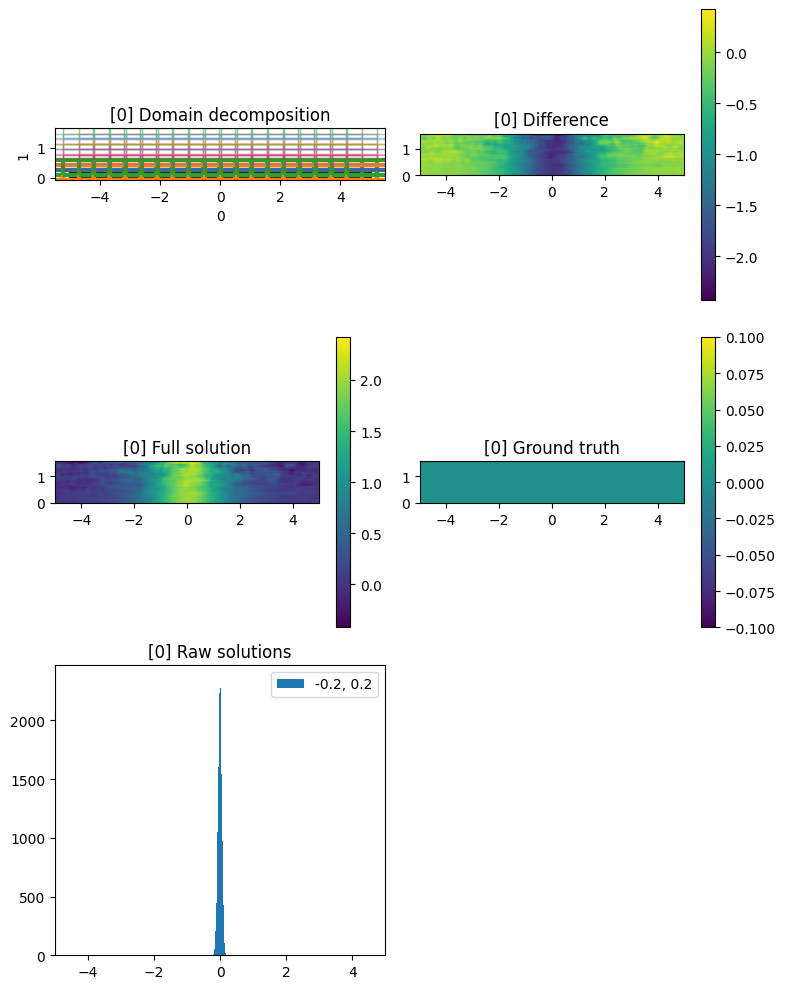

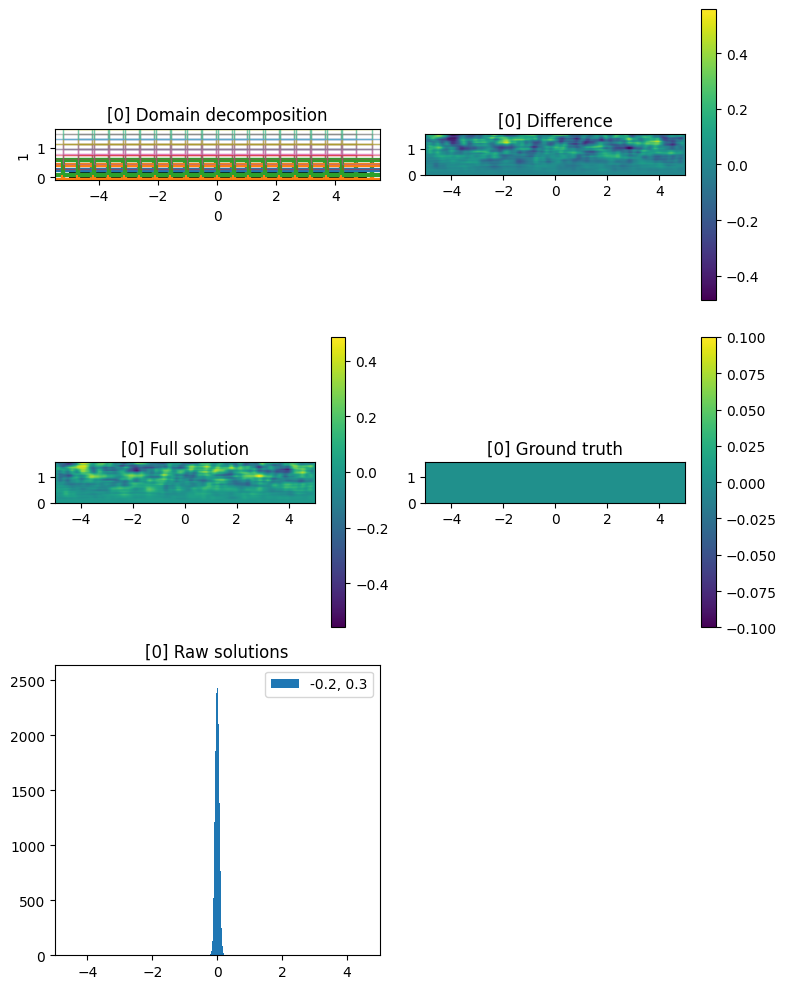

[INFO] 2025-04-01 20:49:34 - saved arrays
[INFO] 2025-04-01 20:49:35 - [i: 1000/50000] loss: 0.0197 rate: 252.7 elapsed: 0.00 hr test
[INFO] 2025-04-01 20:49:36 - [i: 2000/50000] loss: 0.0002 rate: 1395.5 elapsed: 0.00 hr test
[INFO] 2025-04-01 20:49:36 - [i: 2632/50000] Updating active inputs..
[INFO] 2025-04-01 20:49:36 - [i: 2632/50000] Average number of points/dimension in active subdomains: 39.26
[INFO] 2025-04-01 20:49:36 - [i: 2632/50000] Updating active inputs done (0.04 s)
[INFO] 2025-04-01 20:49:36 - [i: 2632/50000] Compiling update step..
[INFO] 2025-04-01 20:49:36 - x_batch
[INFO] 2025-04-01 20:49:36 - (10800, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:36 - x_take
[INFO] 2025-04-01 20:49:36 - (82224, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:36 - x_batch
[INFO] 2025-04-01 20:49:36 - (10800, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:36 - x_take
[INFO] 2025-04-01 20:49:36 - (82224, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:39 - [i: 2632/50000] Compiling don

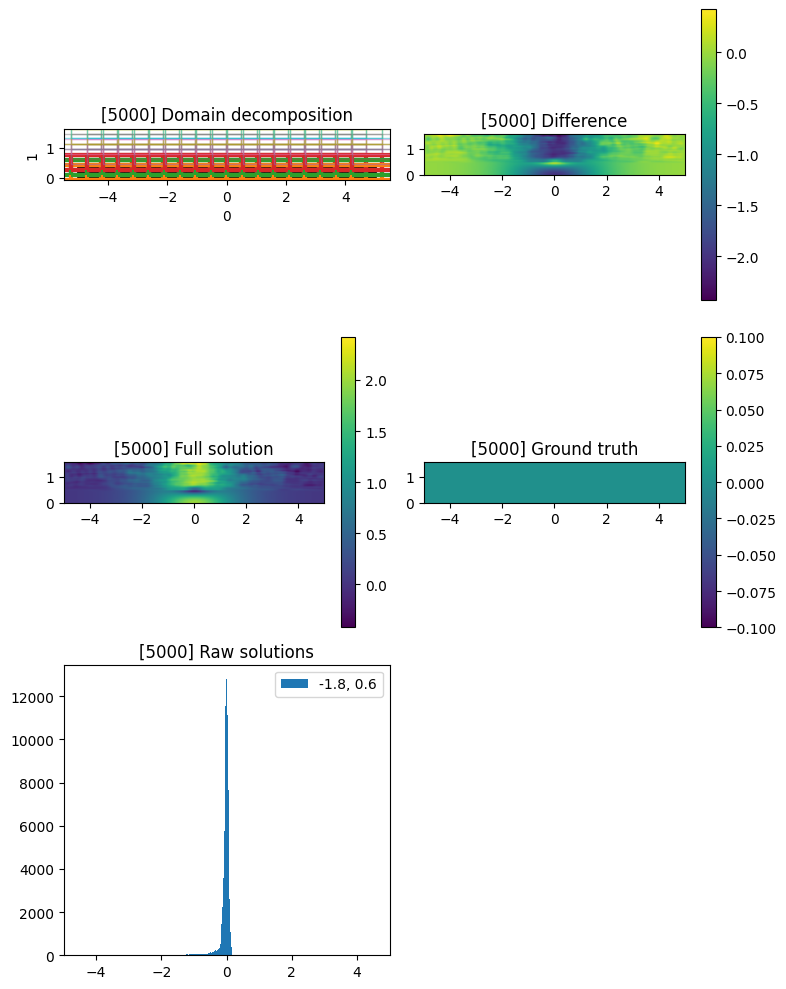

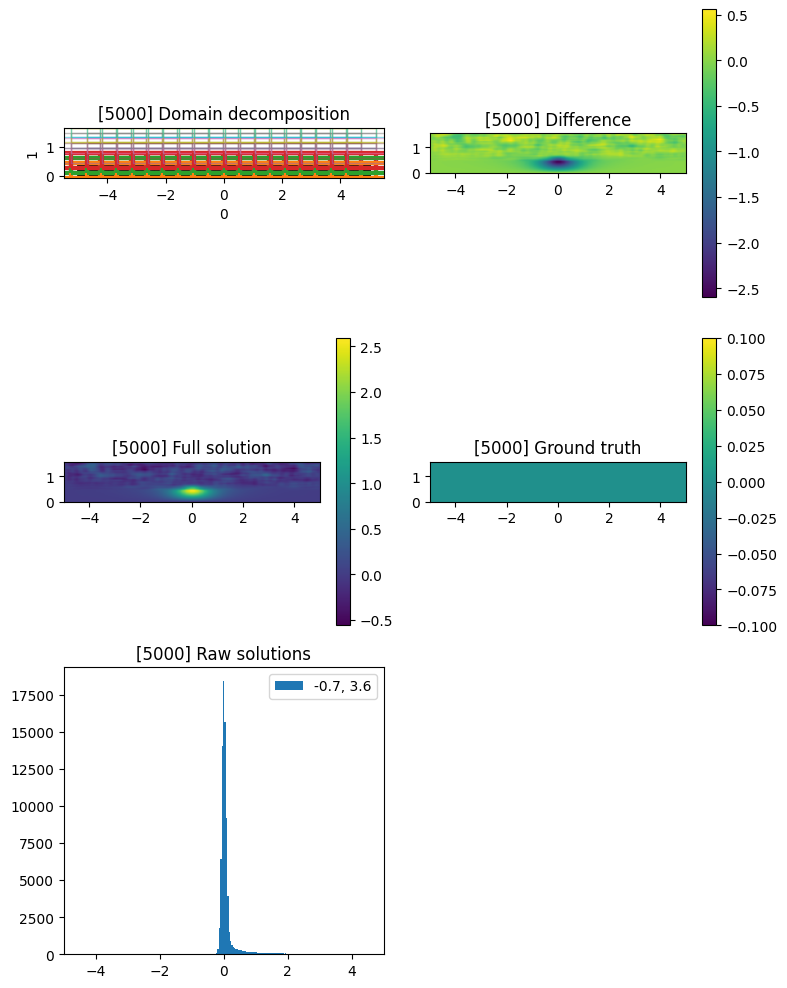

[INFO] 2025-04-01 20:49:44 - saved arrays
[INFO] 2025-04-01 20:49:45 - [i: 6000/50000] loss: 0.0014 rate: 713.5 elapsed: 0.00 hr test
[INFO] 2025-04-01 20:49:47 - [i: 7000/50000] loss: 0.0007 rate: 712.7 elapsed: 0.00 hr test
[INFO] 2025-04-01 20:49:48 - [i: 7895/50000] Updating active inputs..
[INFO] 2025-04-01 20:49:48 - [i: 7895/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-04-01 20:49:50 - [i: 7895/50000] Updating active inputs done (2.54 s)
[INFO] 2025-04-01 20:49:50 - [i: 7895/50000] Compiling update step..
[INFO] 2025-04-01 20:49:50 - x_batch
[INFO] 2025-04-01 20:49:50 - (12400, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:50 - x_take
[INFO] 2025-04-01 20:49:50 - (101638, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:51 - x_batch
[INFO] 2025-04-01 20:49:51 - (12400, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:51 - x_take
[INFO] 2025-04-01 20:49:51 - (101638, 2), float32, JVPTracer
[INFO] 2025-04-01 20:49:54 - [i: 7895/50000] Compiling do

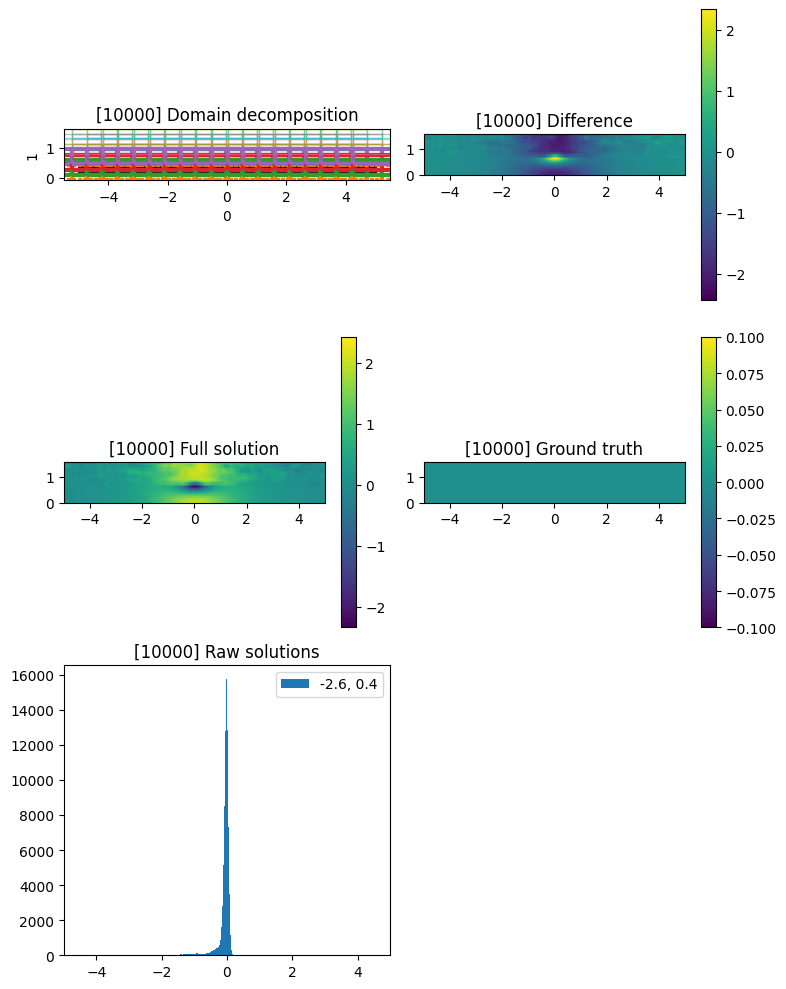

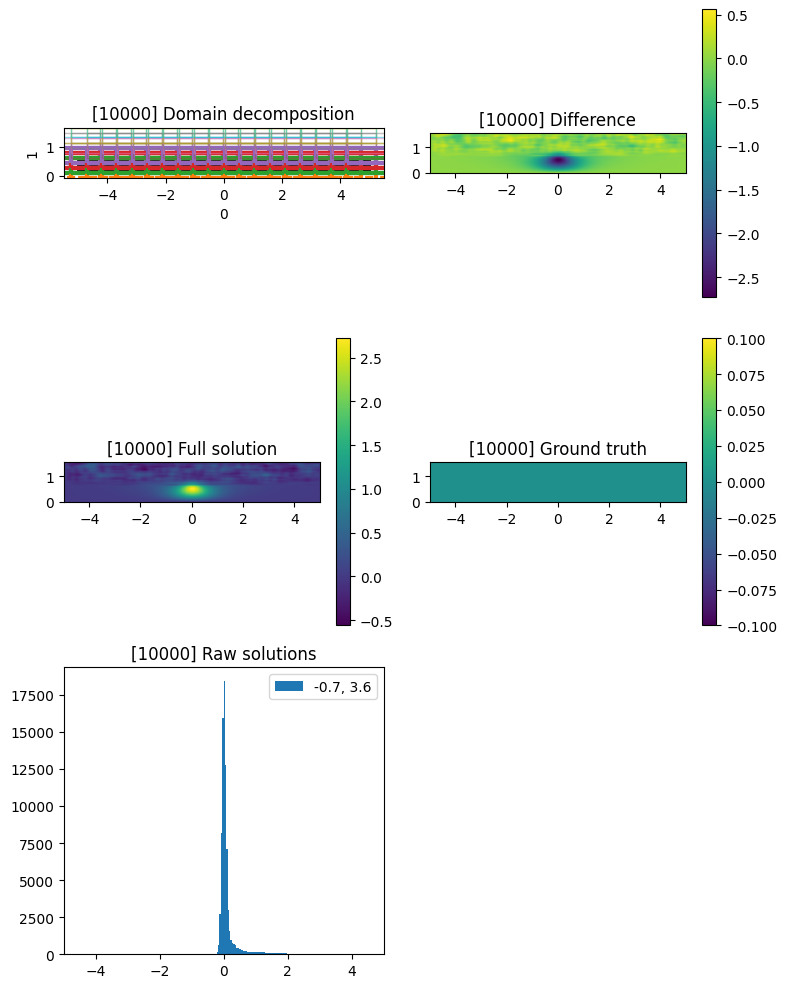

[INFO] 2025-04-01 20:49:59 - saved arrays
[INFO] 2025-04-01 20:50:01 - [i: 11000/50000] loss: 0.0033 rate: 570.0 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:02 - [i: 12000/50000] loss: 0.0032 rate: 570.0 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:04 - [i: 13000/50000] loss: 0.0031 rate: 569.7 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:04 - [i: 13158/50000] Updating active inputs..
[INFO] 2025-04-01 20:50:05 - [i: 13158/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-04-01 20:50:05 - [i: 13158/50000] Updating active inputs done (0.22 s)
[INFO] 2025-04-01 20:50:05 - [i: 13158/50000] Compiling update step..
[INFO] 2025-04-01 20:50:05 - [i: 13158/50000] Compiling done (0.03 s)
[INFO] 2025-04-01 20:50:06 - [i: 14000/50000] loss: 0.0417 rate: 500.8 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:08 - [i: 15000/50000] loss: 0.0176 rate: 569.8 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)
Tru

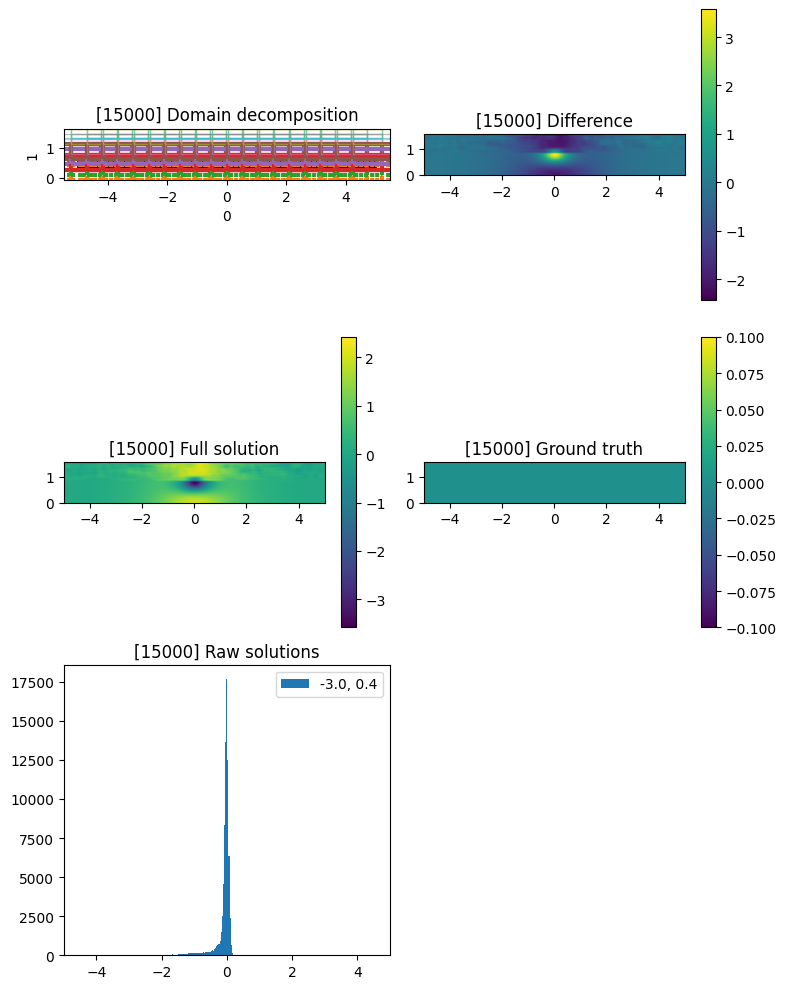

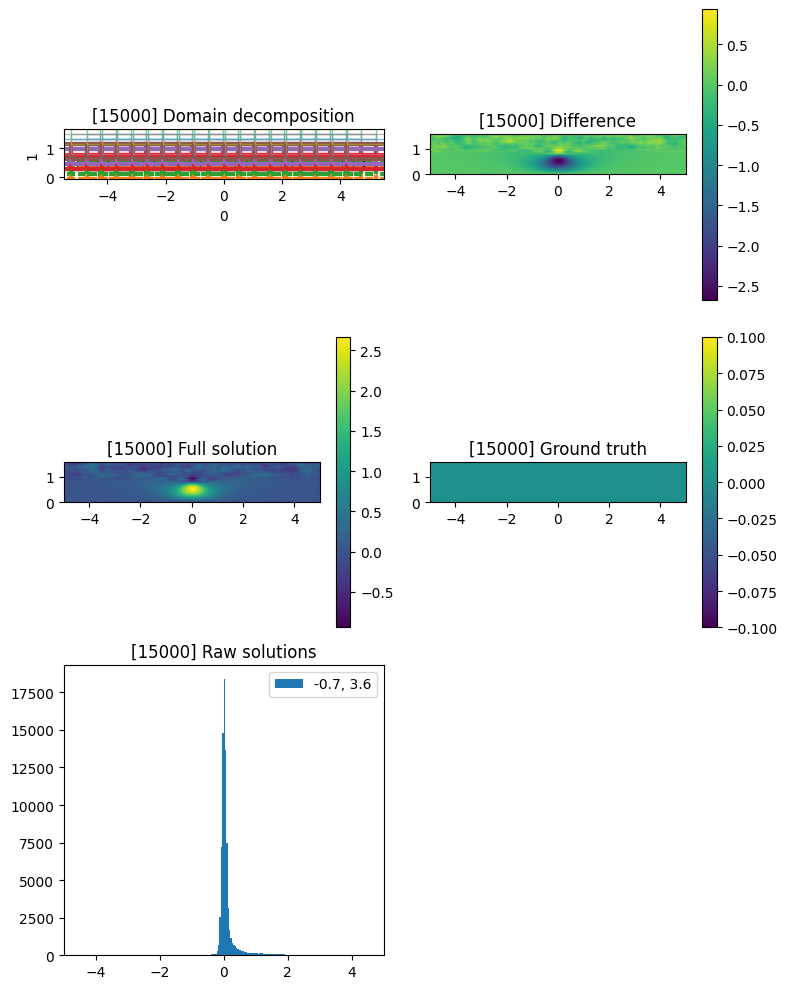

[INFO] 2025-04-01 20:50:09 - saved arrays
[INFO] 2025-04-01 20:50:11 - [i: 16000/50000] loss: 0.0151 rate: 569.7 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:13 - [i: 17000/50000] loss: 0.0148 rate: 569.5 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:15 - [i: 18000/50000] loss: 0.0147 rate: 569.6 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:15 - [i: 18422/50000] Updating active inputs..
[INFO] 2025-04-01 20:50:15 - [i: 18422/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-04-01 20:50:15 - [i: 18422/50000] Updating active inputs done (0.05 s)
[INFO] 2025-04-01 20:50:15 - [i: 18422/50000] Compiling update step..
[INFO] 2025-04-01 20:50:15 - [i: 18422/50000] Compiling done (0.03 s)
[INFO] 2025-04-01 20:50:16 - [i: 19000/50000] loss: 0.0293 rate: 547.2 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:18 - [i: 20000/50000] loss: 0.0244 rate: 570.2 elapsed: 0.01 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)
Tru

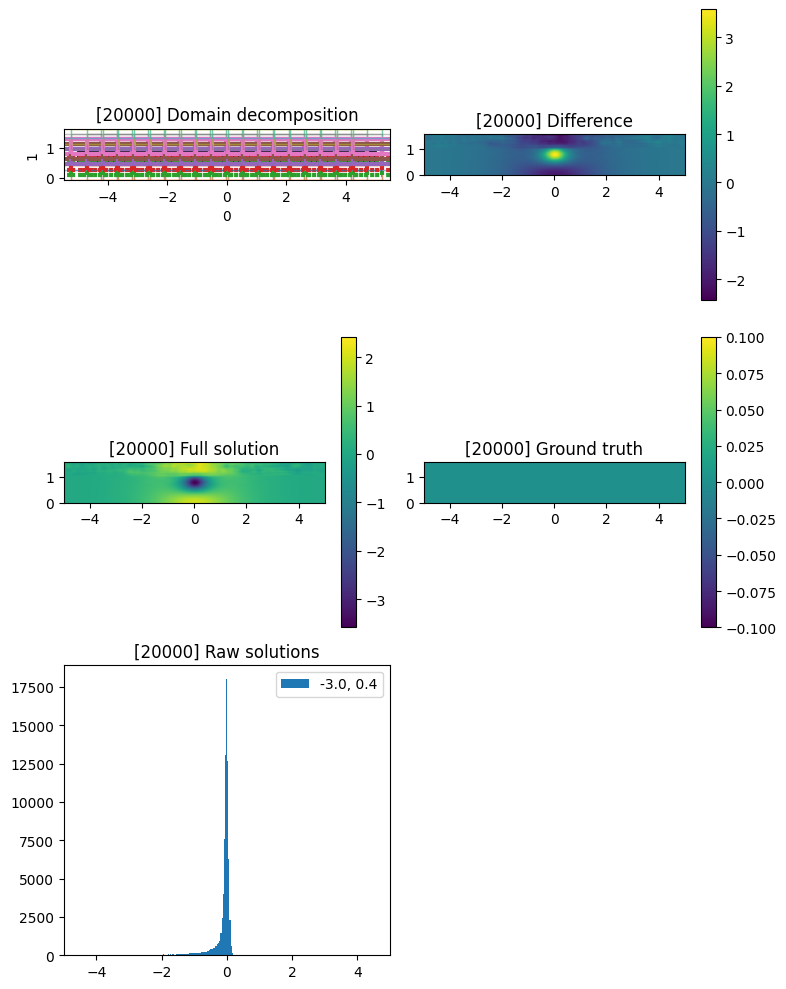

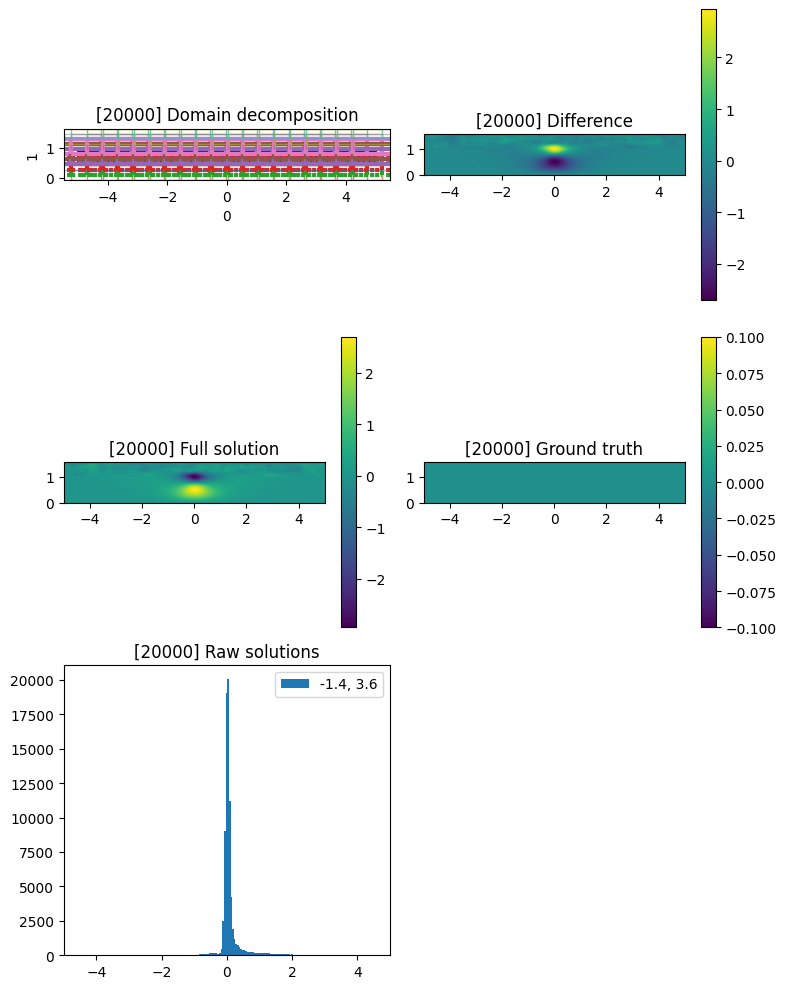

[INFO] 2025-04-01 20:50:19 - saved arrays
[INFO] 2025-04-01 20:50:21 - [i: 21000/50000] loss: 0.0242 rate: 570.0 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:23 - [i: 22000/50000] loss: 0.0242 rate: 570.1 elapsed: 0.01 hr test
[INFO] 2025-04-01 20:50:25 - [i: 23000/50000] loss: 0.0242 rate: 569.9 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:26 - [i: 23685/50000] Updating active inputs..
[INFO] 2025-04-01 20:50:26 - [i: 23685/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-04-01 20:50:26 - [i: 23685/50000] Updating active inputs done (0.05 s)
[INFO] 2025-04-01 20:50:26 - [i: 23685/50000] Compiling update step..
[INFO] 2025-04-01 20:50:26 - [i: 23685/50000] Compiling done (0.03 s)
[INFO] 2025-04-01 20:50:27 - [i: 24000/50000] loss: 0.0292 rate: 547.1 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:29 - [i: 25000/50000] loss: 0.0268 rate: 570.1 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)
Tru

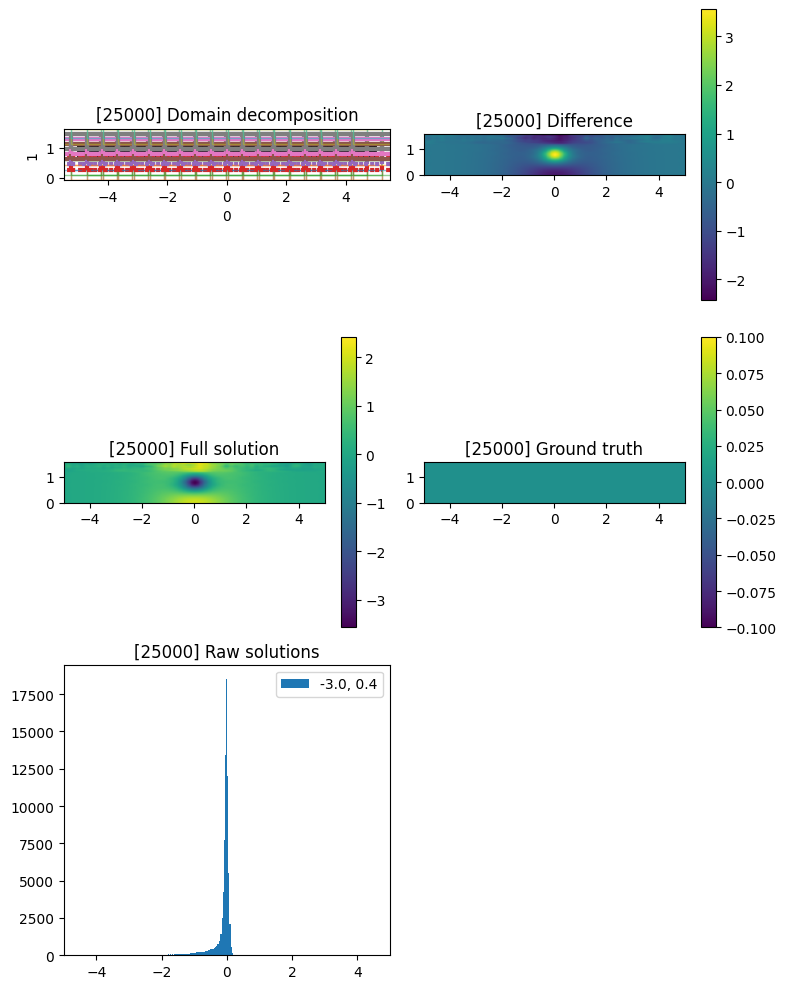

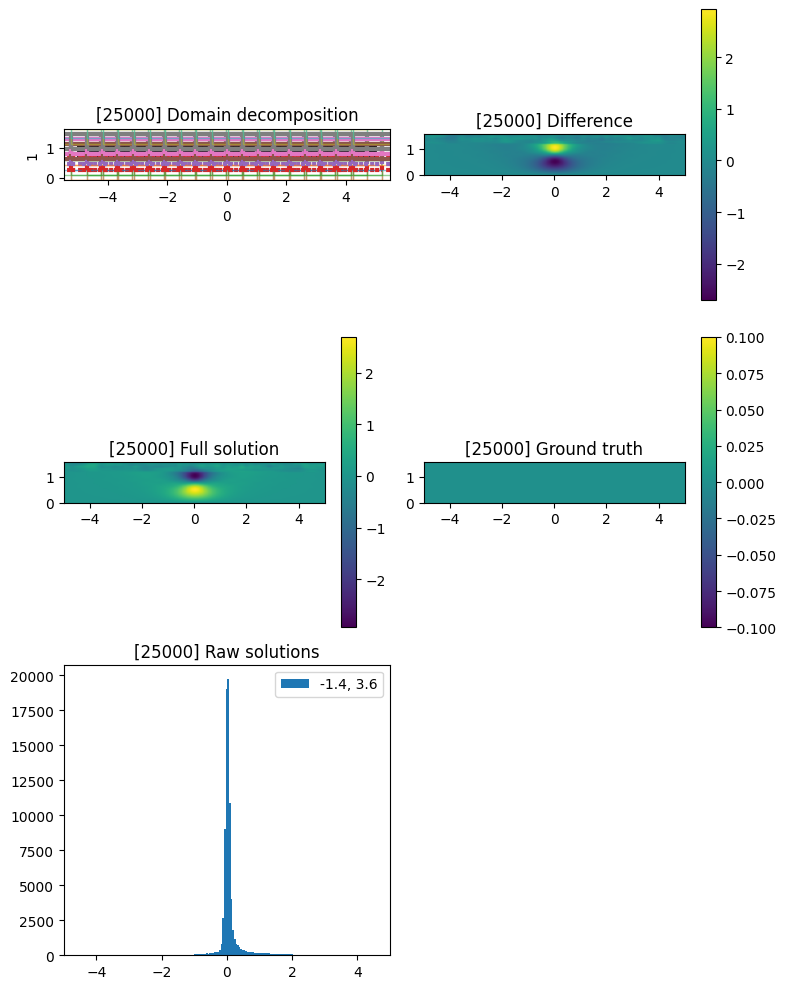

[INFO] 2025-04-01 20:50:30 - saved arrays
[INFO] 2025-04-01 20:50:32 - [i: 26000/50000] loss: 0.0267 rate: 570.5 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:34 - [i: 27000/50000] loss: 0.0266 rate: 569.8 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:35 - [i: 28000/50000] loss: 0.0267 rate: 570.1 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:37 - [i: 28948/50000] Updating active inputs..
[INFO] 2025-04-01 20:50:37 - [i: 28948/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-04-01 20:50:37 - [i: 28948/50000] Updating active inputs done (0.05 s)
[INFO] 2025-04-01 20:50:37 - [i: 28948/50000] Compiling update step..
[INFO] 2025-04-01 20:50:37 - [i: 28948/50000] Compiling done (0.04 s)
[INFO] 2025-04-01 20:50:37 - [i: 29000/50000] loss: 0.0477 rate: 544.5 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:39 - [i: 30000/50000] loss: 0.0173 rate: 570.1 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)
Tru

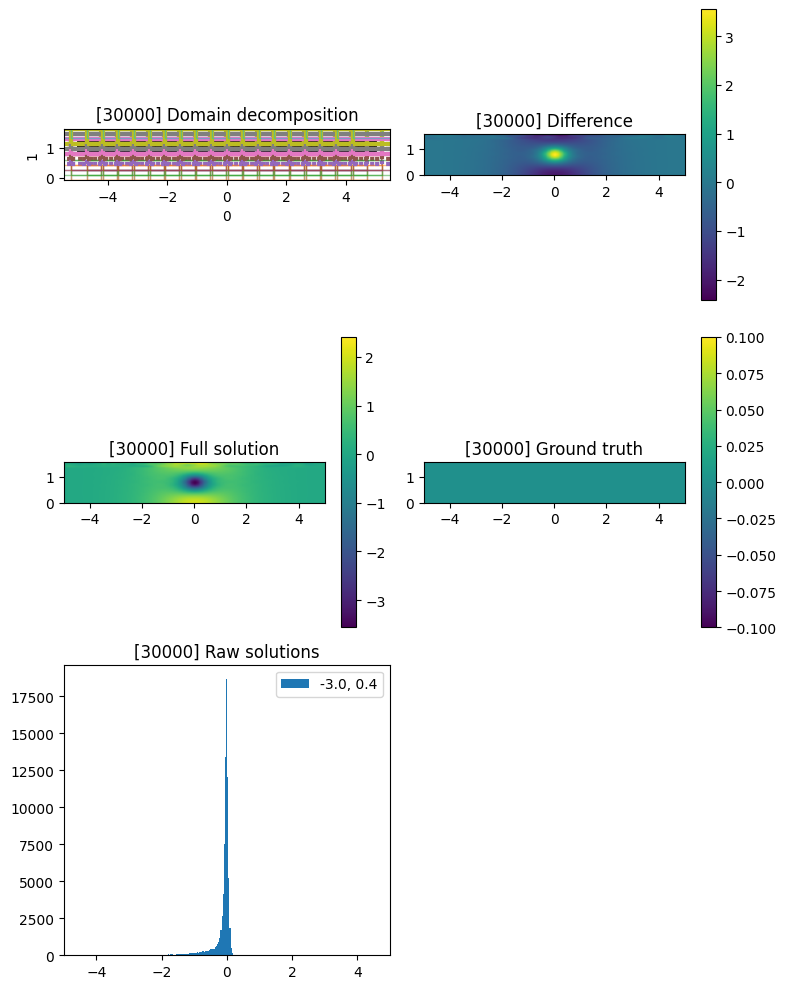

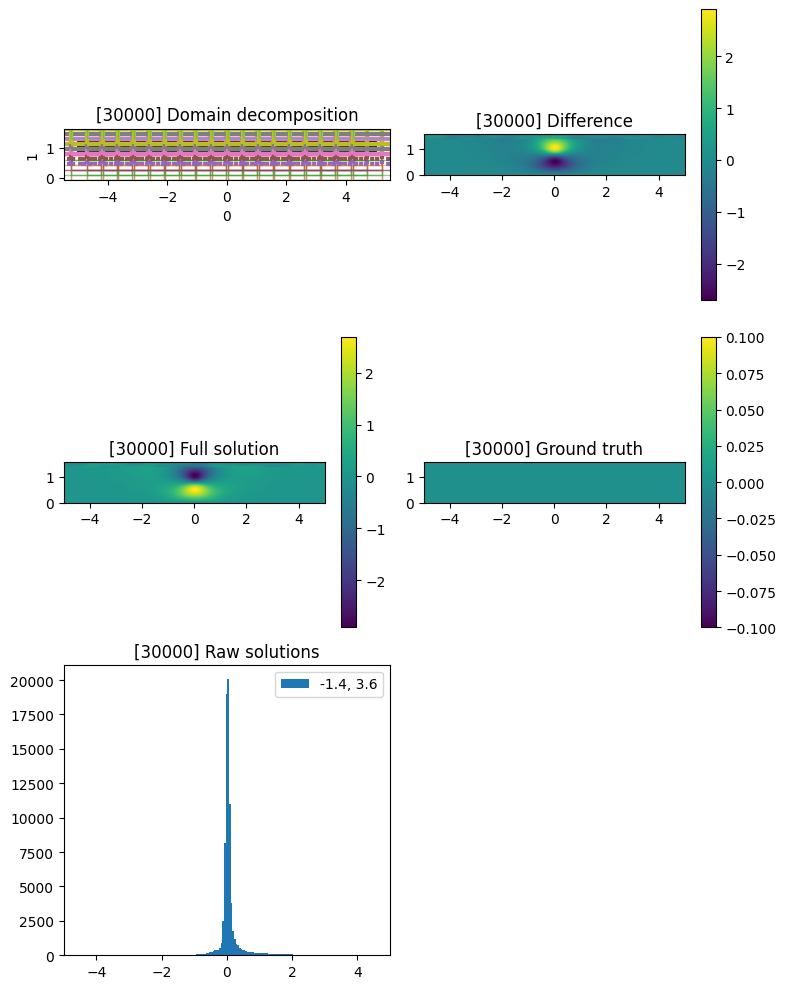

[INFO] 2025-04-01 20:50:40 - saved arrays
[INFO] 2025-04-01 20:50:42 - [i: 31000/50000] loss: 0.0173 rate: 570.3 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:44 - [i: 32000/50000] loss: 0.0173 rate: 570.0 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:46 - [i: 33000/50000] loss: 0.0174 rate: 570.1 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:48 - [i: 34000/50000] loss: 0.0173 rate: 570.3 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:48 - [i: 34211/50000] Updating active inputs..
[INFO] 2025-04-01 20:50:48 - [i: 34211/50000] Average number of points/dimension in active subdomains: 42.07
[INFO] 2025-04-01 20:50:48 - [i: 34211/50000] Updating active inputs done (0.12 s)
[INFO] 2025-04-01 20:50:48 - [i: 34211/50000] Compiling update step..
[INFO] 2025-04-01 20:50:48 - [i: 34211/50000] Compiling done (0.03 s)
[INFO] 2025-04-01 20:50:49 - [i: 35000/50000] loss: 0.0076 rate: 528.9 elapsed: 0.02 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (12400, 2) (200, 50)
Tru

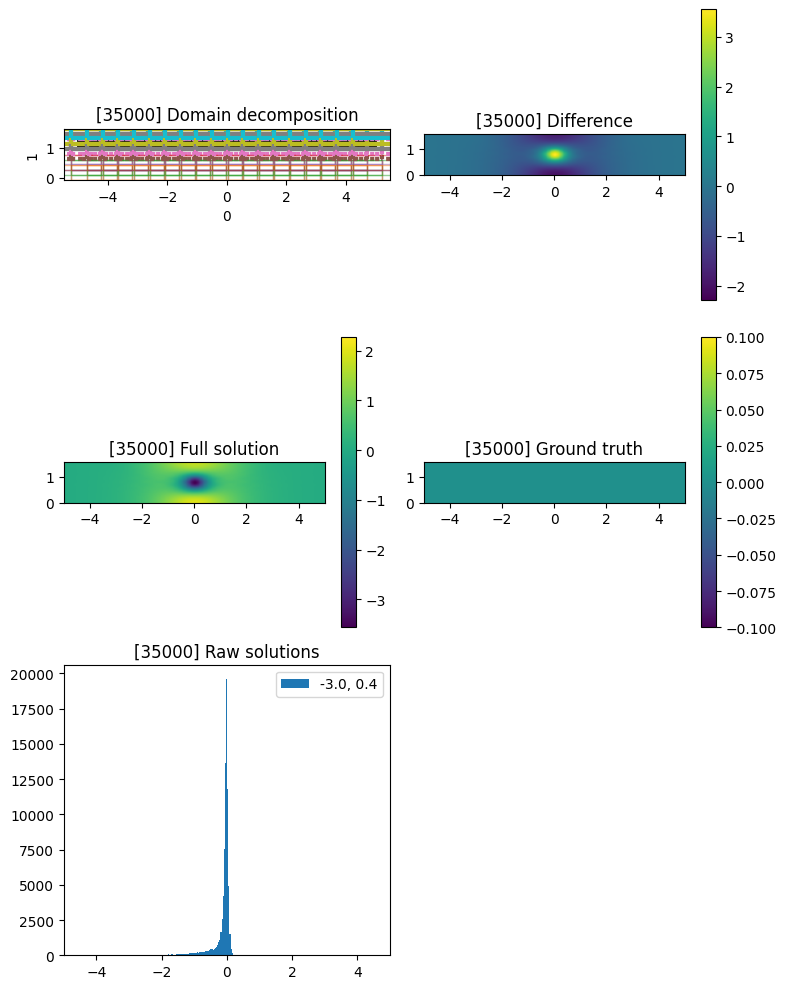

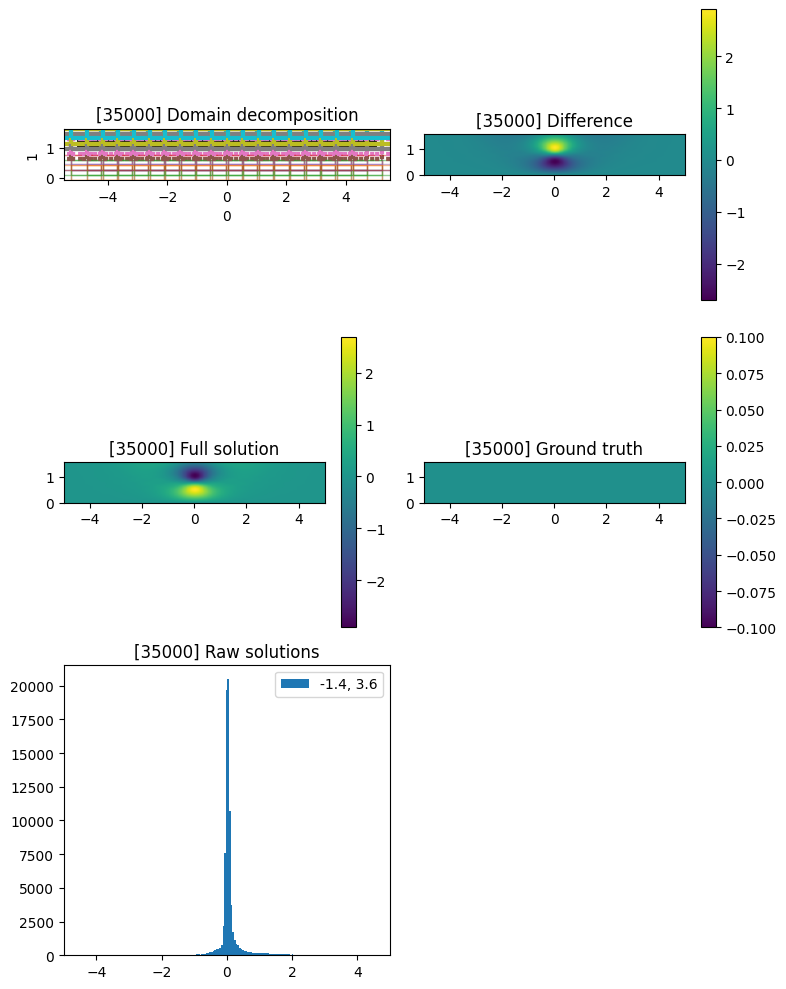

[INFO] 2025-04-01 20:50:51 - saved arrays
[INFO] 2025-04-01 20:50:52 - [i: 36000/50000] loss: 0.0074 rate: 571.4 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:54 - [i: 37000/50000] loss: 0.0075 rate: 570.8 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:56 - [i: 38000/50000] loss: 0.0074 rate: 570.8 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:58 - [i: 39000/50000] loss: 0.0074 rate: 570.9 elapsed: 0.02 hr test
[INFO] 2025-04-01 20:50:59 - [i: 39474/50000] Updating active inputs..
[INFO] 2025-04-01 20:50:59 - [i: 39474/50000] Average number of points/dimension in active subdomains: 39.26
[INFO] 2025-04-01 20:50:59 - [i: 39474/50000] Updating active inputs done (0.14 s)
[INFO] 2025-04-01 20:50:59 - [i: 39474/50000] Compiling update step..
[INFO] 2025-04-01 20:50:59 - x_batch
[INFO] 2025-04-01 20:50:59 - (10800, 2), float32, JVPTracer
[INFO] 2025-04-01 20:50:59 - x_take
[INFO] 2025-04-01 20:50:59 - (82224, 2), float32, JVPTracer
[INFO] 2025-04-01 20:50:59 - x_batch
[INFO] 2025-04-01 20:50

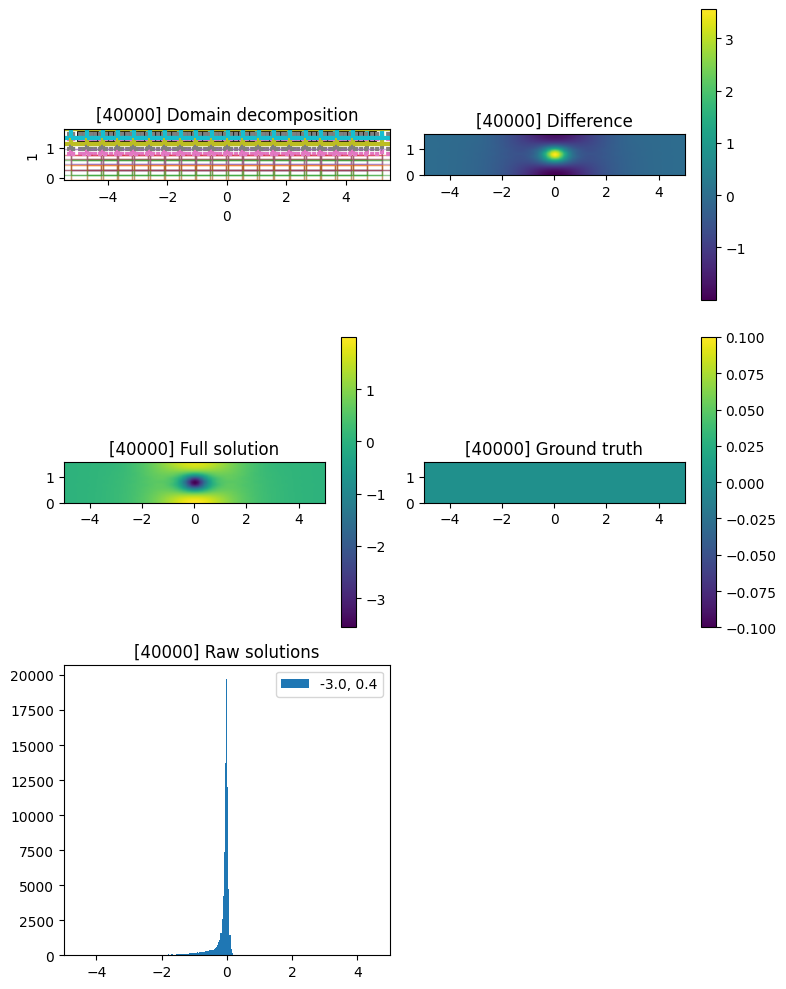

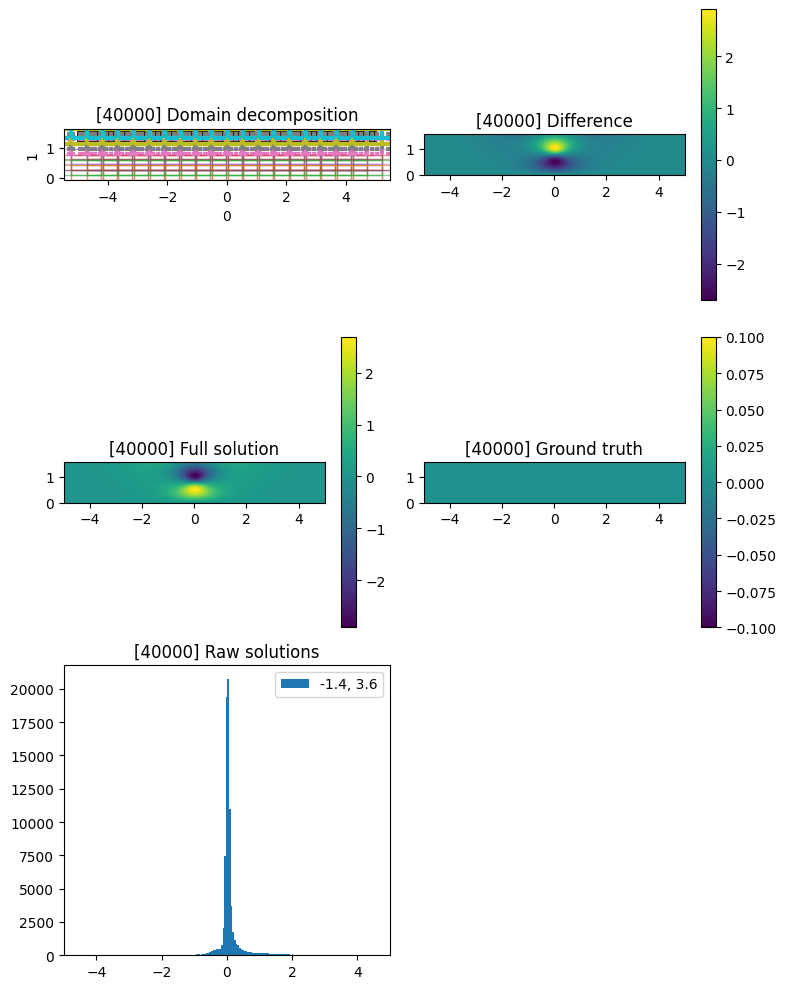

[INFO] 2025-04-01 20:51:04 - saved arrays
[INFO] 2025-04-01 20:51:05 - [i: 41000/50000] loss: 0.0025 rate: 684.3 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:07 - [i: 42000/50000] loss: 0.0027 rate: 684.0 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:08 - [i: 43000/50000] loss: 0.0028 rate: 684.2 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:10 - [i: 44000/50000] loss: 0.0027 rate: 683.9 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:11 - [i: 44737/50000] Updating active inputs..
[INFO] 2025-04-01 20:51:11 - [i: 44737/50000] Average number of points/dimension in active subdomains: 30.23
[INFO] 2025-04-01 20:51:11 - [i: 44737/50000] Updating active inputs done (0.08 s)
[INFO] 2025-04-01 20:51:11 - [i: 44737/50000] Compiling update step..
[INFO] 2025-04-01 20:51:11 - x_batch
[INFO] 2025-04-01 20:51:11 - (6400, 2), float32, JVPTracer
[INFO] 2025-04-01 20:51:11 - x_take
[INFO] 2025-04-01 20:51:11 - (46822, 2), float32, JVPTracer
[INFO] 2025-04-01 20:51:11 - x_batch
[INFO] 2025-04-01 20:51:

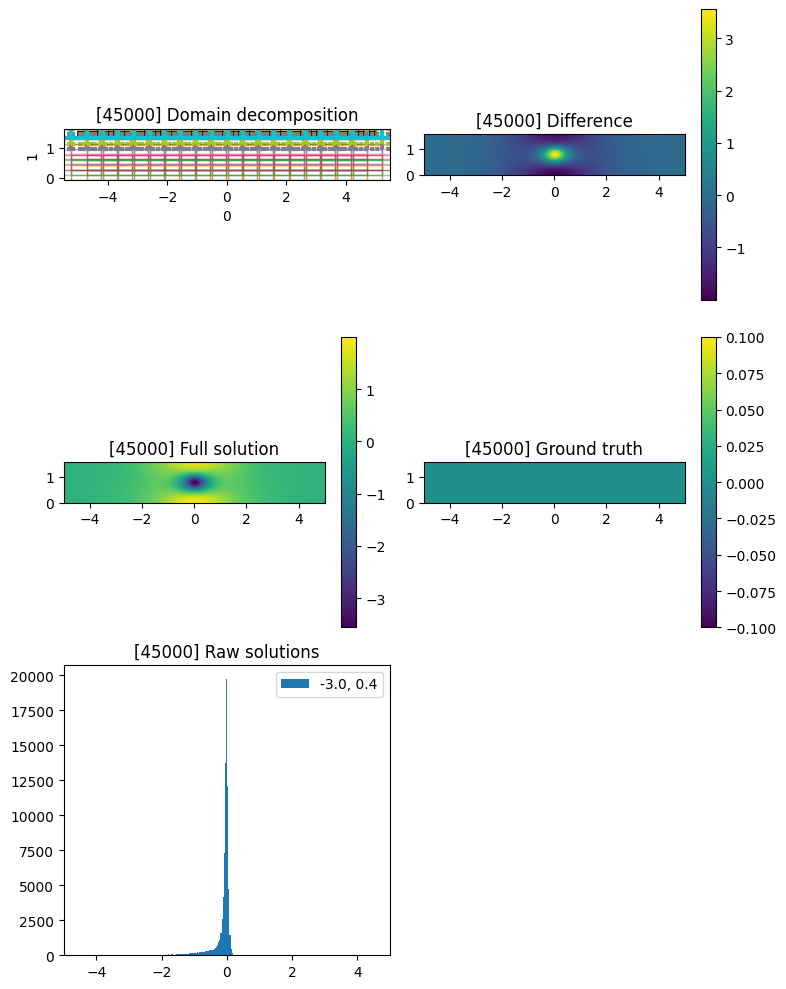

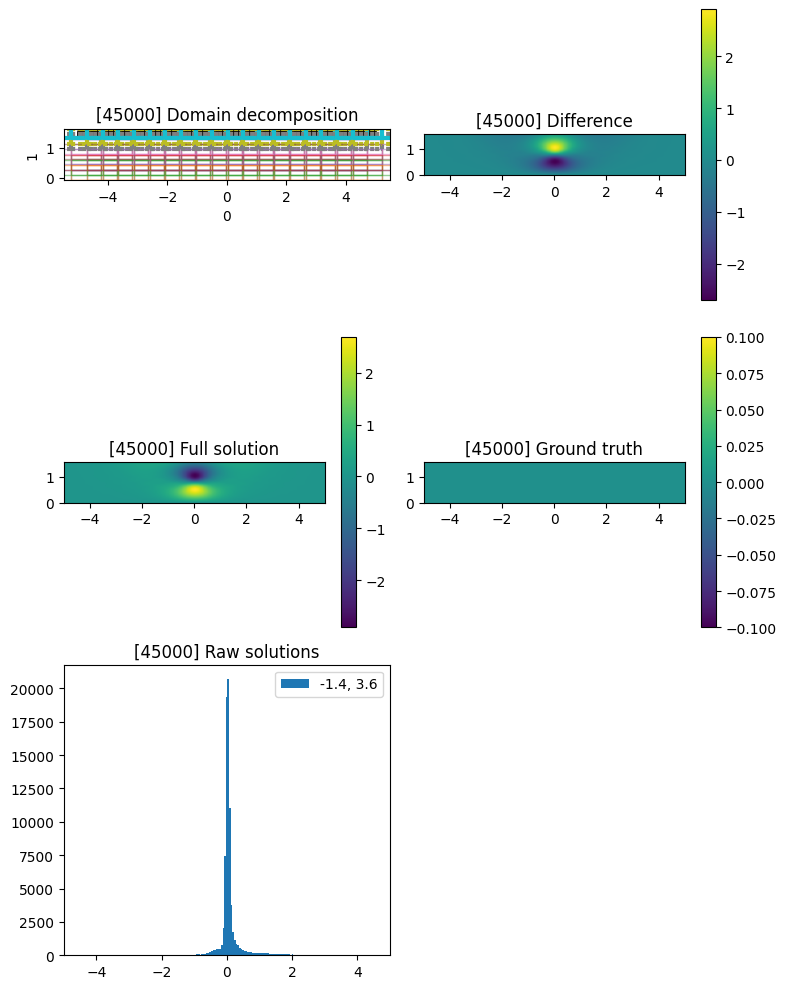

[INFO] 2025-04-01 20:51:16 - saved arrays
[INFO] 2025-04-01 20:51:16 - [i: 46000/50000] loss: 0.0011 rate: 1469.1 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:17 - [i: 47000/50000] loss: 0.0011 rate: 1468.9 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:18 - [i: 48000/50000] loss: 0.0011 rate: 1467.7 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:19 - [i: 49000/50000] loss: 0.0012 rate: 1467.4 elapsed: 0.03 hr test
[INFO] 2025-04-01 20:51:19 - [i: 50000/50000] loss: 0.0010 rate: 1468.8 elapsed: 0.03 hr test
(10000, 2) (10000, 2) (10000, 2) (79800, 2) (79800, 1) (79800, 2) (6400, 2) (200, 50)
True


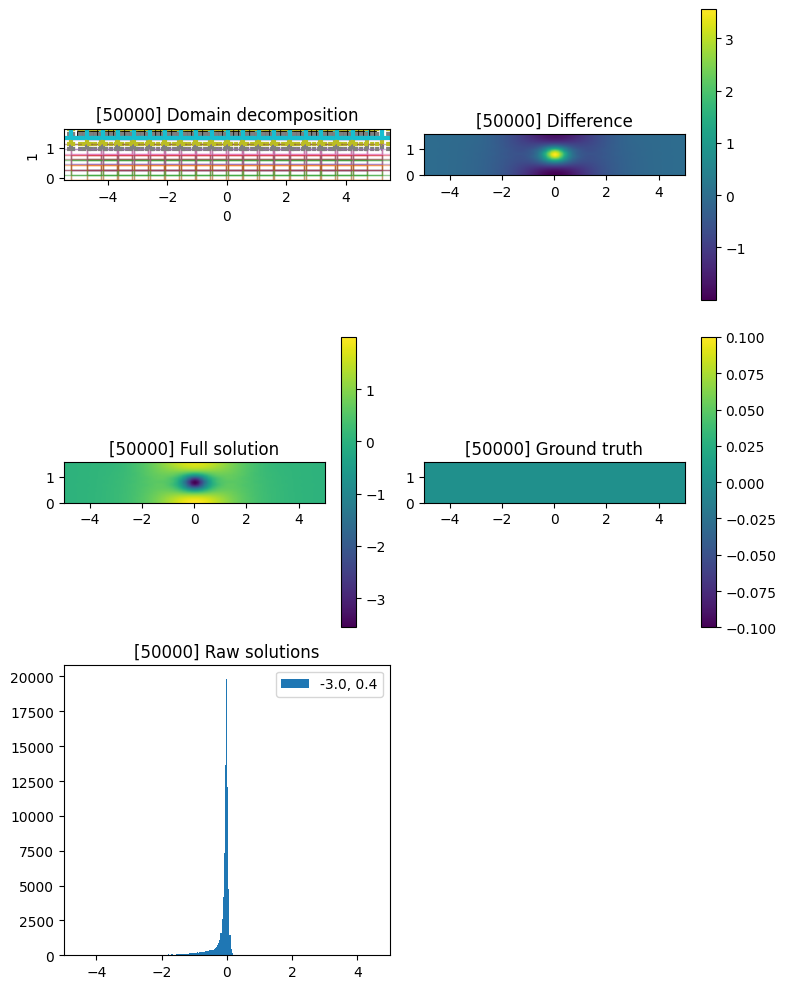

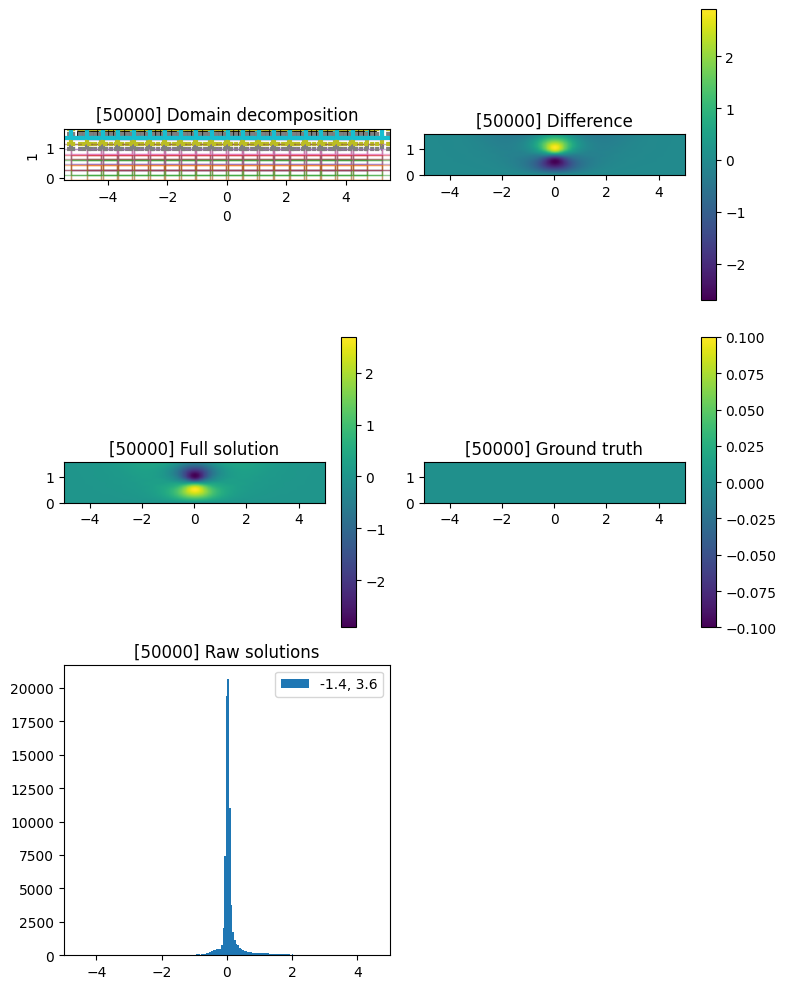

[INFO] 2025-04-01 20:51:20 - saved arrays
[INFO] 2025-04-01 20:51:20 - [i: 50000/50000] Training complete


In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, LegendreKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = -5., 5.
t_min, t_max = 0., jnp.pi/2
subdomain_xs=[np.linspace(x_min, x_max, 20), np.linspace(t_min, t_max, 10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,t_min]),
        xmax=np.array([x_max,t_max])
        ),
    problem=Schrodinger1D,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 32, 2),
    # ),
    # network=ChebyshevKAN,
    network=LegendreKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=2,
        degree=15
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((400,100),),
    n_test=(200,50),
    n_steps=50000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()